[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cfloy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cfloy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Classification Report:
               precision    recall  f1-score   support

          no       0.60      1.00      0.75         6
         yes       1.00      0.73      0.85        15

    accuracy                           0.81        21
   macro avg       0.80      0.87      0.80        21
weighted avg       0.89      0.81      0.82        21



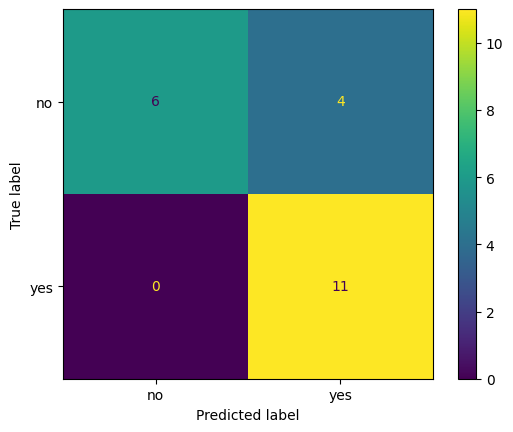

In [32]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from openpyxl.workbook import Workbook
from pandasql import sqldf
import pandasql as sql
import string
from IPython.display import FileLink
import seaborn as sns
%matplotlib inline

# Train/Test Data
colnames=['text', 'county', 'state', 'season', 'label']
comments_df = pd.read_csv('comments_bf.csv', sep=",", names=colnames, skiprows=1)

# Real Data
bf_enc_df = pd.read_csv('BF_ENCOUNTER_INFO.csv')
bf_colnames = ['ENC_ID', 'ENC_COMMENTS',	'LOC_DEETS', 'ENC_COUNTY', 'NUM_ENC', 'ENC_STATE', 'STATE_ABRV', 'ENC_SEASON', 'FIPS']

query = "SELECT * FROM bf_enc_df WHERE STATE_ABRV = 'TN';"

state_df = sqldf(query)

states = [ 'AK', 'AL', 'AR',	 'AZ',	 'CA',	 'CO',	 'CT',	 'FL',	 'GA',	 'KY',	 'MA',	 'MD',	 'OK',	 'TN',	 'VT']

# Text Preprocessing
def pre_proc(text):
    rem_punc = [c for c in text if c not in string.punctuation]

    rem_punc = ''.join(rem_punc)

    return[w for w in rem_punc.split() if w.lower not in stopwords.words("english")]

cpp = comments_df['text'].apply(pre_proc)

transformer = CountVectorizer(analyzer=pre_proc).fit(comments_df['text'])

bow = transformer.transform(comments_df['text'])

tfidf_transformer = TfidfTransformer().fit(bow)

text_tfidf = tfidf_transformer.transform(bow)

# Train/Test Model
X_train, X_test, Y_train, Y_test = train_test_split(comments_df['text'], comments_df['label'], test_size=0.2, random_state=42)
pline = Pipeline([
    ('bow', CountVectorizer(analyzer=pre_proc)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC(kernel='linear'))
])

pline.fit(X_train, Y_train)

# for loop used for running application data in chunks as running all of the data at once causes Jupyter to crash
'''for state in states:
    query = "SELECT * FROM bf_enc_df WHERE STATE_ABRV = " +"'"+ state+"'" + ";"

    state_df = sqldf(query)

    predictions = pline.predict(state_df['ENC_COMMENTS'])
    print(state, predictions)
    state_df['confirmed_sighting'] = predictions

    state_df.to_excel('pred_'+state+'.xlsx', index=False)'''

predictions = pline.predict(X_test)
print("Classification Report:\n",classification_report(predictions, Y_test))

ConfusionMatrixDisplay.from_predictions(Y_test, predictions)

plt.show()